In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob
#For SVM
from sklearn.svm import SVC

## Import Data

In [2]:
#Import Dataset
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)

            volatility      index  crash_label  price_change  volume_change  \
date                                                                          
1998-03-31   -0.628541  000001.SS            0      0.187709      -0.127147   
1998-06-30   -0.628541  000001.SS            0      0.504913      -0.127147   
1998-09-30   -0.625680  000001.SS            1     -0.795446      -0.127147   
1998-12-31   -0.631403  000001.SS            0     -0.843210      -0.127147   
1999-03-31   -0.629515  000001.SS            0     -0.082838      -0.127147   
...                ...        ...          ...           ...            ...   
2018-12-31   -0.493234      ^SSMI            0     -0.800378      -0.127147   
2019-03-31   -0.529809      ^SSMI            0      0.914383      -0.127147   
2019-06-30   -0.458321      ^SSMI            0      0.217264      -0.127147   
2019-09-30   -0.388212      ^SSMI            0     -0.010617      -0.127147   
2019-12-31   -0.351813      ^SSMI            0      

# Build the model

In [3]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Hyperparameter Tuning
    param_grid = {"C": [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    grid_search = GridSearchCV(SVC(probability=True), param_grid, verbose=2)
    try:
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model = SVC(C=best_params['C'], gamma=best_params['gamma'], probability=True)
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    decision_values = model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, decision_values)
    fpr, tpr, thresholds = roc_curve(y_test, decision_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix,
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_importance = np.abs(model.dual_coef_).sum(axis=0)
    for name, importance in zip(features_columns, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END ...................

[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ...................................C=100, gamma=0.1; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END ..................................C=100, gamma=0.01; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s
[CV] END .................................C=100, gamma=0.001; total time=   0.0s
[CV] END ...................

[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ....................................C=10, gamma=0.1; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ...................................C=10, gamma=0.01; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END ..................................C=10, gamma=0.001; total time=   0.0s
[CV] END ...................

[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END .....................................C=1, gamma=0.1; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ....................................C=1, gamma=0.01; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................................C=1, gamma=0.001; total time=   0.0s
[CV] END ...................

[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.1s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.1s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.1s
[CV] END .................................C=0.1, gamma=0.001; total time=   0.1s
[CV] END ...................

[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.1s
[CV] END ...............................C=1000, gamma=0.0001; total time=   0.0s
[CV] END ...............................C=1000, gamma=0.0001; total time=   0.0s
[CV] END ...............................C=1000, gamma=0.0001; total time=   0.0s
[CV] END ...................

In [4]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_SVM_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2005-12-31,"[[126, 1], [11, 2]]",0.666667,0.153846,0.250000,0.914286,0.292770,...,0.178921,0.325277,0.268419,3.716169,0.801691,0.493912,3.487465,1.528489,2.697940,10.000000
1,1998-03-31,2005-12-31,2006-03-31,2009-06-30,"[[105, 5], [26, 4]]",0.444444,0.133333,0.205128,0.778571,0.470562,...,0.221055,1.000000,0.834739,0.693348,0.815130,0.227443,1.000000,0.582732,1.000000,0.922239
2,1998-03-31,2009-06-30,2009-09-30,2012-12-31,"[[123, 9], [6, 2]]",0.181818,0.250000,0.210526,0.892857,0.327327,...,1.215079,0.803155,1.081048,0.834602,3.034565,1.239002,0.664276,1.970059,1.768554,2.090286
3,1998-03-31,2012-12-31,2013-03-31,2016-06-30,"[[124, 5], [8, 3]]",0.375000,0.272727,0.315789,0.907143,0.304725,...,3.181197,0.843719,3.454399,1.949752,0.943904,1.530970,0.346975,0.382498,0.979969,1.139503
4,1998-03-31,2016-06-30,2016-09-30,2019-12-31,"[[125, 14], [0, 1]]",0.066667,1.000000,0.125000,0.900000,0.316228,...,1.986340,3.233873,2.102991,0.864444,5.806035,0.029050,0.177471,0.417925,2.513371,1.526317


# Feature Importance

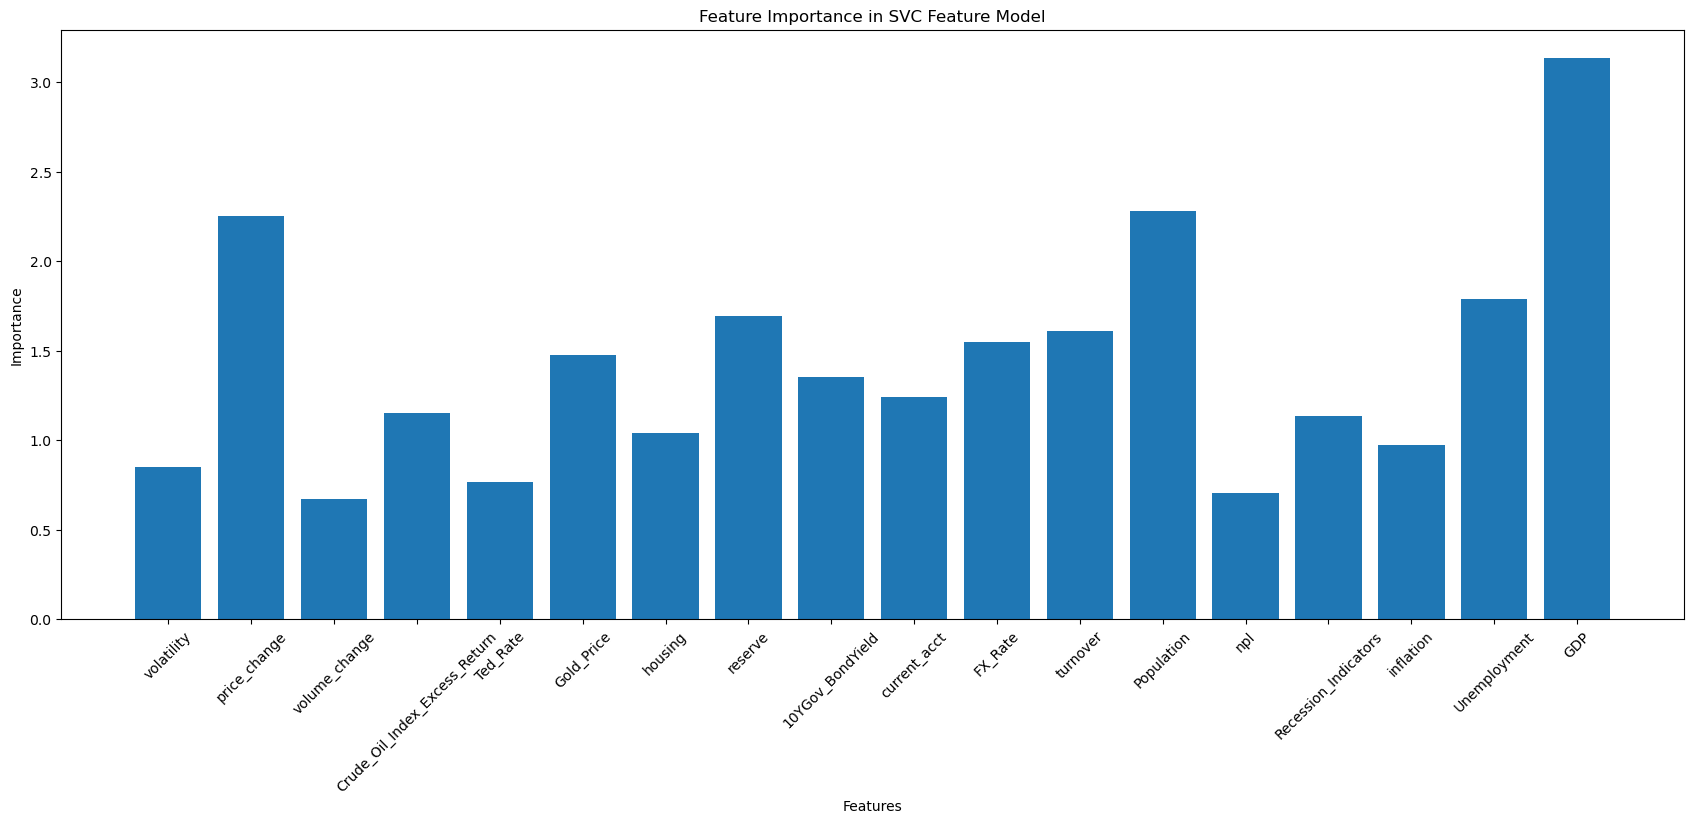

In [5]:
model_name = "SVC Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [6]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8088050444794174


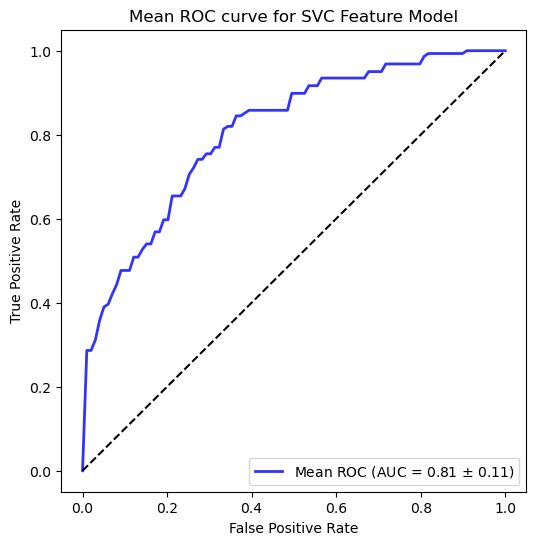

In [7]:
plot_roc_curve(evaluation_df, model_name)

# Vistualization

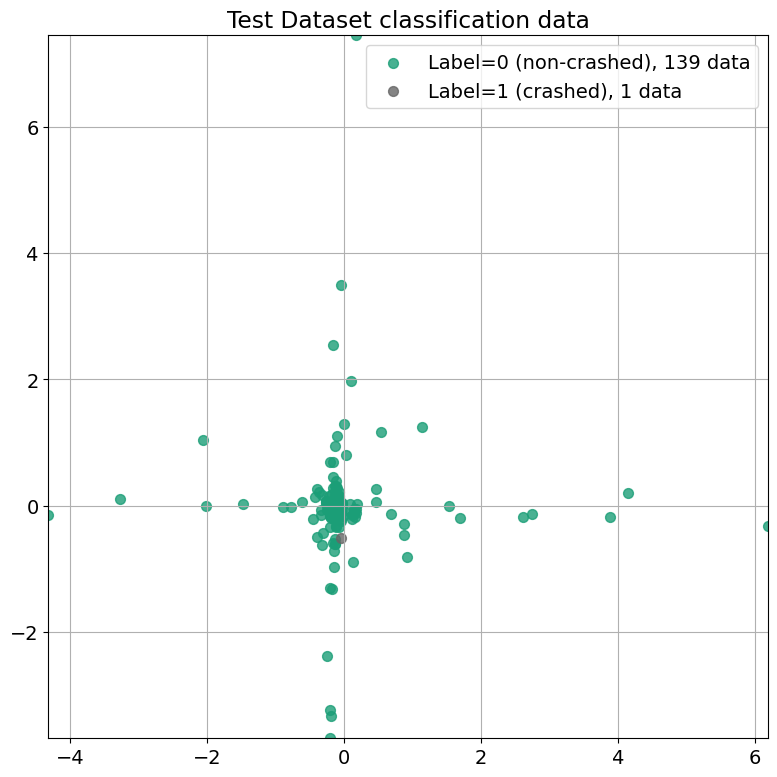

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

dx = X_test
dy = y_test
class_names = ['non-crashed','crashed']

classes, class_num = np.unique(dy, return_counts=True)
dx = PCA(n_components=2).fit_transform(dx)
dx = StandardScaler().fit_transform(dx)
dx_train, dx_test, dy_train, dy_test = \
    train_test_split(dx, dy, test_size=0.2, random_state=0)
plt.figure(figsize=(8, 8))
plt.rcParams['font.size'] = 14
plt.title('Test Dataset classification data')

color = [cm.Dark2.colors[0], cm.Dark2.colors[-1]]
for label in classes:
    data = dx[dy==label]
    plt.scatter(*data.T, color=color[label], s=50, alpha=0.8,
                label=f'Label={label} ' + \
                      f'({class_names[label]}), ' + \
                      f'{class_num[label]} data')
plt.legend() 
plt.grid(True)
plt.xlim([np.amin(dx.T[0]), np.amax(dx.T[0])])
plt.ylim([np.amin(dx.T[1]), np.amax(dx.T[1])])
plt.tight_layout()
plt.show()

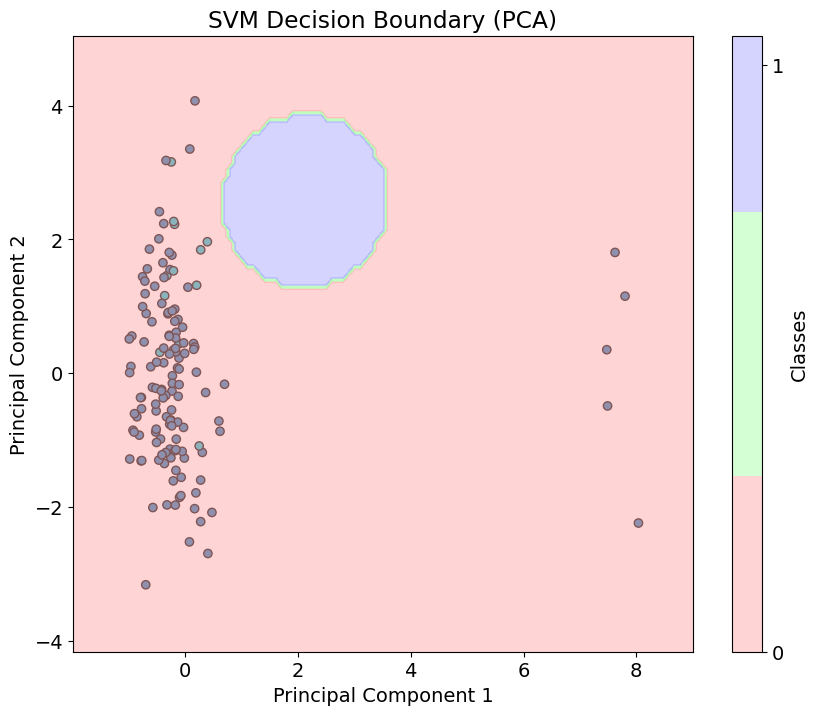

In [28]:


# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Train the SVM model
model = SVC(C=best_params['C'], gamma=best_params['gamma'], probability=True)
model.fit(X_pca, y_test)

# Generate meshgrid for decision boundary visualization
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
XY = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(XY)

# Reshape Z to have the same dimensions as xx and yy
Z = Z.reshape(xx.shape)

# Create a 2D scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab10', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Boundary (PCA)')

# Plot decision regions
cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

# Add colorbar legend
classes = ['Class 0', 'Class 1', 'Class 2']
bounds = [0, 1, 2, 3]
plt.colorbar(ticks=bounds, label='Classes', boundaries=bounds, values=np.arange(3), ax=plt.gca())
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ....................................C=1000, gamma=1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END ...................

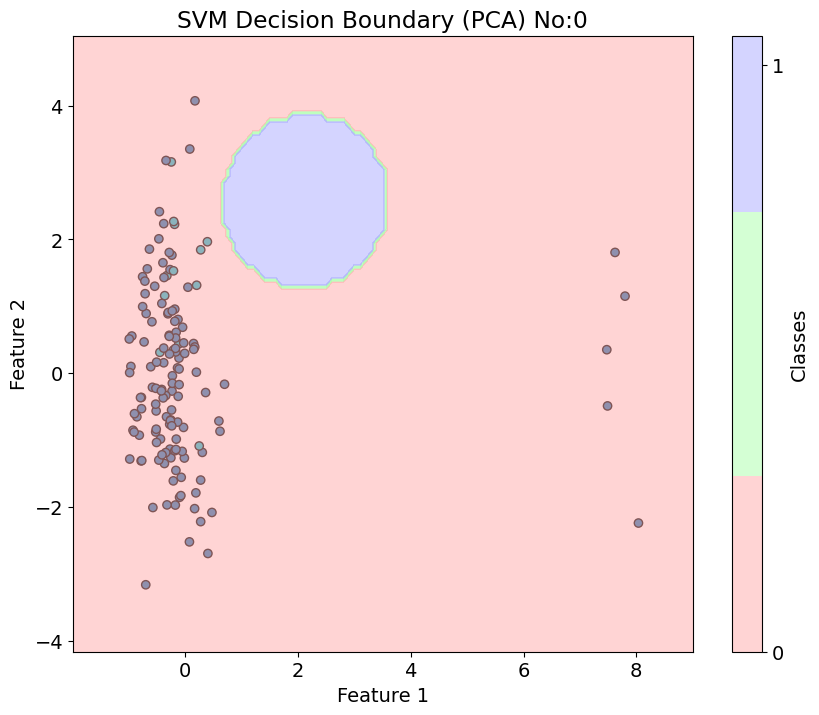

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ...............................C=1000, gamma=0.0001; total time=   0.0s
[CV] END ...................

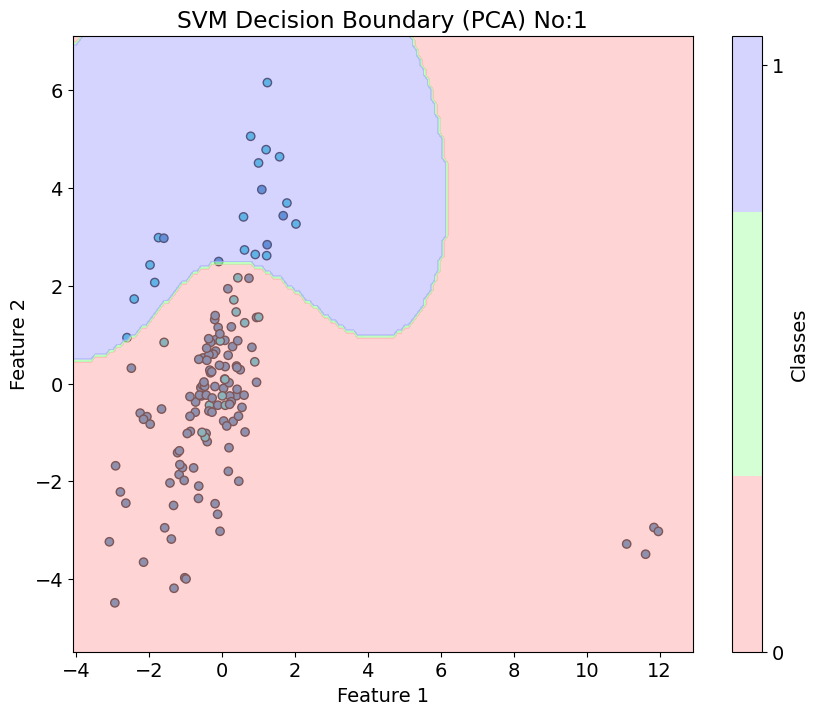

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END .....................................C=0.1, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ................................C=1000, gamma=0.001; total time=   0.0s
[CV] END ...................

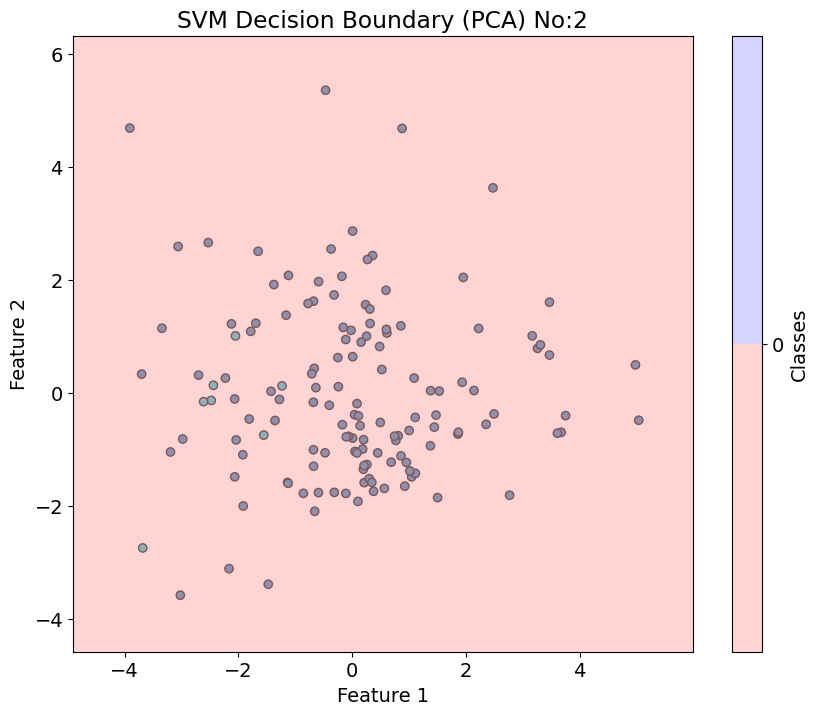

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.0s
[CV] END ..................................C=0.

[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END ...................

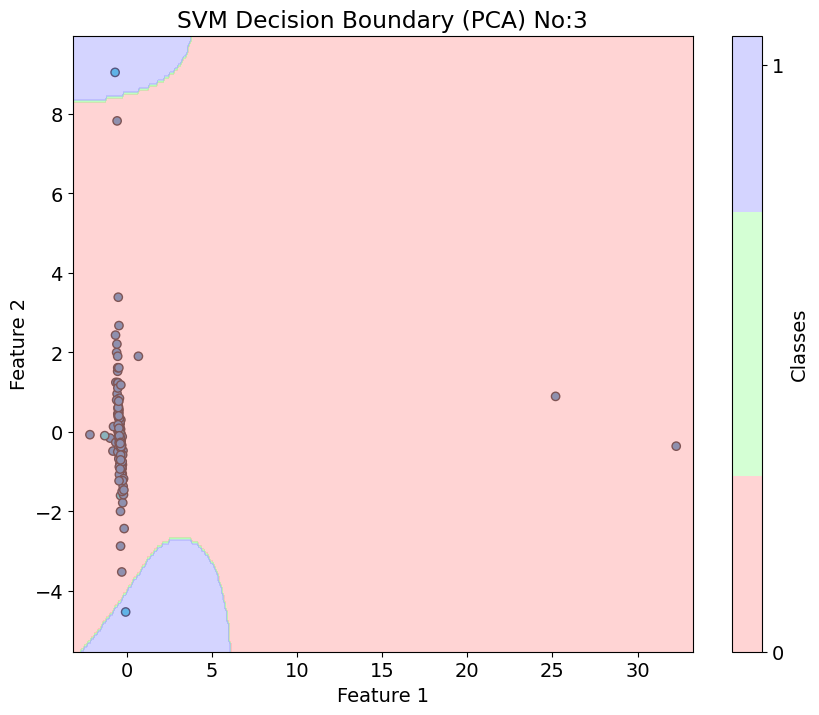

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END .....................................C=0.1, gamma=1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.1s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.1s
[CV] END ..................................C=0.

[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ....................................C=1000, gamma=1; total time=   0.1s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END ..................................C=1000, gamma=0.1; total time=   0.0s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END .................................C=1000, gamma=0.01; total time=   0.1s
[CV] END ...................

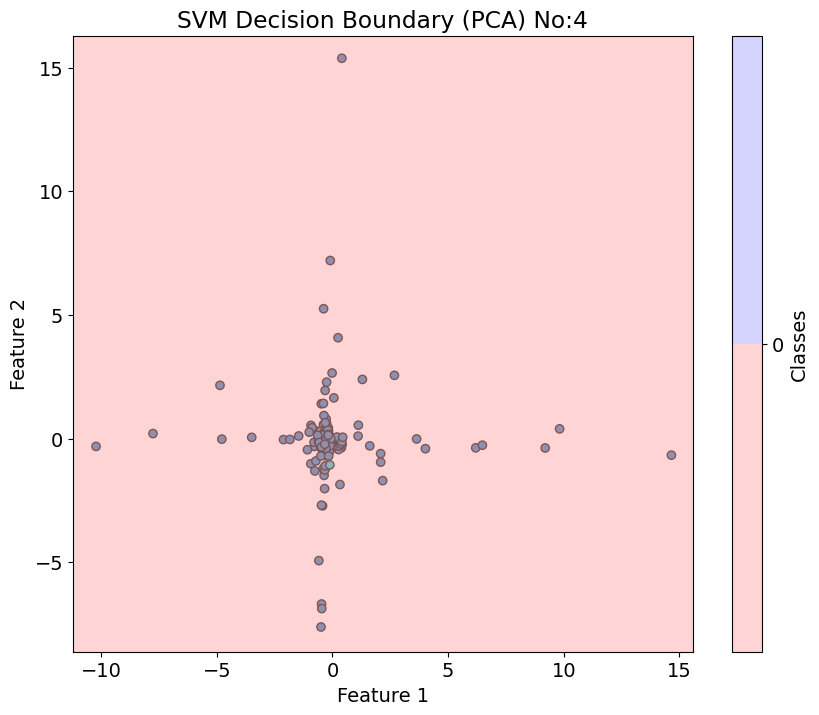

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
i=0

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Hyperparameter Tuning
    param_grid = {"C": [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
    grid_search = GridSearchCV(SVC(probability=True), param_grid, verbose=2)
    try:
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)
        
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)

    # Train the SVM model
    model = SVC(C=best_params['C'], gamma=best_params['gamma'], probability=True)
    model.fit(X_pca, y_test)
    
    # Generate meshgrid for decision boundary visualization
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    XY = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(XY)

    # Reshape Z to have the same dimensions as xx and yy
    Z = Z.reshape(xx.shape)

    # Create a 2D scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab10', edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title('SVM Decision Boundary (PCA) No:'+ str(i))

    # Plot decision regions
    cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)

    # Add colorbar legend
    classes = ['Class 0', 'Class 1', 'Class 2']
    bounds = [0, 1, 2, 3]
    plt.colorbar(ticks=bounds, label='Classes', boundaries=bounds, values=np.arange(3), ax=plt.gca())
    plt.show()
    
    i = i + 1